# Deliverable 4: Final Report

# 1. Introduction


Since the beginning of the covid-19 pandemic in 2020, remote work has been on the rise globally (Brynjolfsson, E. et al., 2020). This drastic change in the way companies operate poses numerous challenges and opportunities for both employers and employees. Given the potential increases in productivity (Galanti, Teresa et al., 2021) among remote workers and the obvious decrease in operating costs for companies, it would be insightful to see if these factors point to a difference in salaries among data science professionals. Since the nature of most data science jobs allows fully remote work, it would be informative to look at salary differences between fully-remote and conventional work.

This raises an interesting question: **does salary differ between full-remote and conventional positions for full-time data science professionals?** We will provide an estimate of the mean salary for both groups(remote and conventional workers) and conduct a two-sample t-test in an attepmt to provide evidence for there being a difference between the two groups. Given the skewed nature of the salaries in our dataset, we will use the inter-quartile range to quantify the spread of the data. 


To answer our question, we discovered a dataset originally aggregated by [ai-jobs.net](https://salaries.ai-jobs.net/) through [Kaggle](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries). This dataset includes 607 observations with 11 factors: year, experience level, full/part-time, job titles, salary values in different currencies, employees location, remote ratio, company locations, and company sizes (more detials see 2.2).  We take the `salary_in_usd` as our response variables and take `remote_ratio` as our explanatory variable.

In [1]:
library(readr)
library(tidyr)
library(infer)
library(repr)
library(dbplyr)
library(tidyverse)
library(cowplot)
library(ggplot2)
library(digest)
library(lubridate)
library(scales)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.6     ✔ dplyr   1.0.9
✔ tibble  3.1.7     ✔ stringr 1.4.0
✔ purrr   0.3.4     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::ident()  masks dbplyr::ident()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::sql()    masks dbplyr::sql()


Attaching package: ‘lubridate’


The following object is masked from ‘package:cowplot’:

    stamp


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




# 2. Methods and Results
*Here is where you’ll include your work from the “Preliminary Results” in your proposal, along with the additional results you planned to conduct, as indicated in the “Methods: Plan” section of your proposal.* 

*Be sure to **incorporate feedback from the teaching team and your peers (as relevant)**, or **make any improvements based on your own improved understanding of the project** (now that more time has passed since the proposal).*



*Specifically, in addition to what is requested in the “Preliminary Results” section of the proposal, we are looking for the following components:*

- *Describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.*
- *Make sure to interpret the results you obtain. It’s not enough to just state what a 90% confidence interval is, for example.*
- *Ensure your tables and/or figures are labeled with a figure/table number.*
- *Do you think one of **bootstrapping or asymptotics is more appropriate than the other**? Why or why not? Explain why you think both methods gave you similar/different results, and whether you think one is more trustworthy than the other.*

### 2.1 Preliminary results and improvements in plan

- Hi Ayush :)

*Specifically, in addition to what is requested in the “Preliminary Results” section of the proposal, we are looking for the following components:*

***Describe in written English the methods you used** to perform your analysis from beginning to end that **narrates the code** the does the analysis.*

- choose only mean and given up median for normality condition  
- take them as two groups/populations to compare the difference
- is the overall sample mean still meaningful and indicative? 

### 2.2 Methods and analysis

In [31]:
# Given the absence of an official API for R language from Kaggle, 
# we had to transfer the .csv file to Github for the required direct import process.

ds_salaries <- read_csv("https://raw.githubusercontent.com/CalicoCalliope/ds_salaries_r/main/ds_salaries.csv")

glimpse(ds_salaries)

New names:
• `` -> `...1`
Rows: 607 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): experience_level, employment_type, job_title, salary_currency, empl...
dbl (5): ...1, work_year, salary, salary_in_usd, remote_ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 607
Columns: 12
$ ...1               <dbl> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…
$ work_year          <dbl> 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 202…
$ experience_level   <chr> "MI", "SE", "SE", "MI", "SE", "EN", "SE", "MI", "MI…
$ employment_type    <chr> "FT", "FT", "FT", "FT", "FT", "FT", "FT", "FT", "FT…
$ job_title          <chr> "Data Scientist", "Machine Learning Scientist", "Bi…
$ salary             <dbl> 70000, 260000, 85000, 20000, 150000, 72000, 190000,…
$ salary_currency    <chr> "EUR", "USD", "GBP", "USD", "USD", "USD", "USD", "H…
$ salary_in_usd      <dbl> 79833, 260000, 109024, 20000, 150000, 72000, 190000…
$ employee_residence <chr> "DE", "JP", "GB", "HN", "US", "US", "US", "HU", "US…
$ remote_ratio       <dbl> 0, 0, 50, 0, 50, 100, 100, 50, 100, 50, 0, 0, 0, 10…
$ company_location   <chr> "DE", "JP", "GB", "HN", "US", "US", "US", "HU", "US…
$ company_size       <chr> "L", "S", "M", "S", "L", "L", "S", "L", "L", "S", "…


In [36]:
df <- ds_salaries %>%

    # filter only fulltime position to create sample for the targeted population:
    filter(employment_type=="FT") %>% 

    select(salary_in_usd,  # select converted salaries so all values are on the same scale
           remote_ratio,  # select remote ratio as the explanatory variable
           
           # include following potential indicators for more in-depth interests and future questions:
           company_location,  # shown in ISO 3166 country code
           # company_size,  # S: < 50 employees, M: 50~250 employees, L: > 250 employees
           experience_level)  # EN: Entry-level, MI: Mid-level, SE: Senior-level, EX: Executive-level

head(df)

salary_in_usd,remote_ratio,company_location,experience_level
<dbl>,<dbl>,<chr>,<chr>
79833,0,DE,MI
260000,0,JP,SE
109024,50,GB,SE
20000,0,HN,MI
150000,50,US,SE
72000,100,US,EN


In [37]:
sample_stats <- df %>% 
    summarise(mean = mean(salary_in_usd),
             median = median (salary_in_usd))

mean_overall<- sample_stats[1] %>% pull()
median_overall <- sample_stats[2] %>% pull()

mean_overall
median_overall

[1] 113468

[1] 104196

Warning message:
“Removed 2 rows containing missing values (geom_bar).”


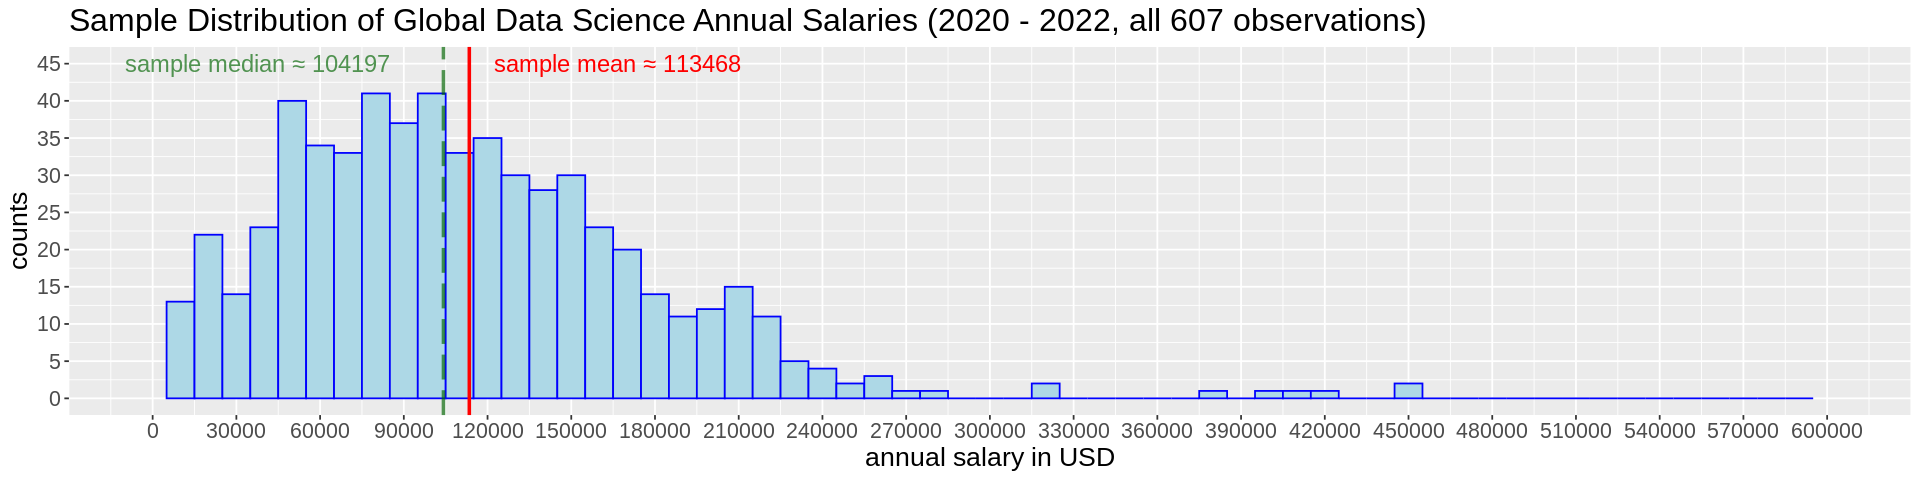

In [39]:
options(repr.plot.width = 16, repr.plot.height = 4)
options("scipen"=10, "digits"=4)

all_salary_plot  <- df %>% 
    ggplot(aes(x = salary_in_usd)) + 
    geom_histogram(binwidth = 10000, colour = 'blue', fill = 'light blue') +
    labs(title = "Sample Distribution of Global Data Science Annual Salaries (2020 - 2022, all 607 observations)",
         x = 'annual salary in USD',
         y = 'counts') + 
        theme(text = element_text(size = 16)) +
    
    # add in sample mean and sample meadian as reference:
    geom_vline(xintercept = mean_overall, colour = 'red', size = 1, linetype = "solid") +
        annotate("text", x = mean_overall, y = 45,label = "sample mean ≈ 113468", color = "red", size=5, hjust = -0.1) +
    geom_vline(xintercept = median_overall, colour = 'dark green', alpha = 0.66, size = 1, linetype = "longdash") +
        annotate("text", x = median_overall, y = 45, label = "sample median ≈ 104197", color = "dark green", alpha = 0.66, size=5, hjust = 1.2)+ 

    # refine the limits and breaks of the x and y scales:
    scale_y_continuous(limits = c(0, 45), breaks = seq(0, 45, 5)) +
    scale_x_continuous(limits = c(0, 600001), breaks = seq(0, 600001, 30000)) 


all_salary_plot 

Given the purpose of the key question and the distribution of `remote_ratio` of this dataset:

In [6]:
# Although remote_ration is a double<dbl>, it has only three values: 
# 0%(onsite), 50%(hybrid), 100% (fully remote).  

ratio_value_count <- df %>% 
    summarise(onsite = sum(remote_ratio == 0),
              hybrid = sum(remote_ratio == 50),
              fully_remote = sum(remote_ratio == 100))
              
ratio_value_count

onsite,hybrid,fully_remote
<int>,<int>,<int>
126,92,370


From here onward, we divide the data into two groups:
- `fully_remote`
- `non_fully_remote` or "conventional"

In [40]:
remote_binary <- df %>% 
    mutate(fully_remote = (remote_ratio == 100)) %>% 
    select(-remote_ratio) 
head(remote_binary)

salary_in_usd,company_location,experience_level,fully_remote
<dbl>,<chr>,<chr>,<lgl>
79833,DE,MI,FALSE
260000,JP,SE,FALSE
109024,GB,SE,FALSE
20000,HN,MI,FALSE
150000,US,SE,FALSE
72000,US,EN,TRUE


In [145]:
# 1. fully_remote: remote_ratio == 100, all 100%(fully-remote) 
fully_remote <- remote_binary %>% 
    filter(fully_remote == TRUE)
# head(fully_remote)

fully_remote_mean <- fully_remote %>% 
    summarise(mean = mean(salary_in_usd)) %>% 
    pull()


# 2. non_fully_remote:  remote_ratio != 100, combine both 0%(onsite) and 50%(hybrid),
non_fully_remote <- remote_binary %>% 
    filter(fully_remote == FALSE)
# head(non_fully_remote)

non_fully_remote_mean <- non_fully_remote %>% 
    summarise(mean = mean(salary_in_usd)) %>% 
    pull()


cat(" The sample mean of the fully-remote group is", fully_remote_mean, "USD,","\n","and the sample mean of the non-fully-remote group is", round(non_fully_remote_mean, 5), "USD.")


 The sample mean of the fully-remote group is 122875 USD, 
 and the sample mean of the non-fully-remote group is 97502 USD.

lower_ci,upper_ci
<dbl>,<dbl>
115418,130148


lower_ci,upper_ci
<dbl>,<dbl>
89219,105745


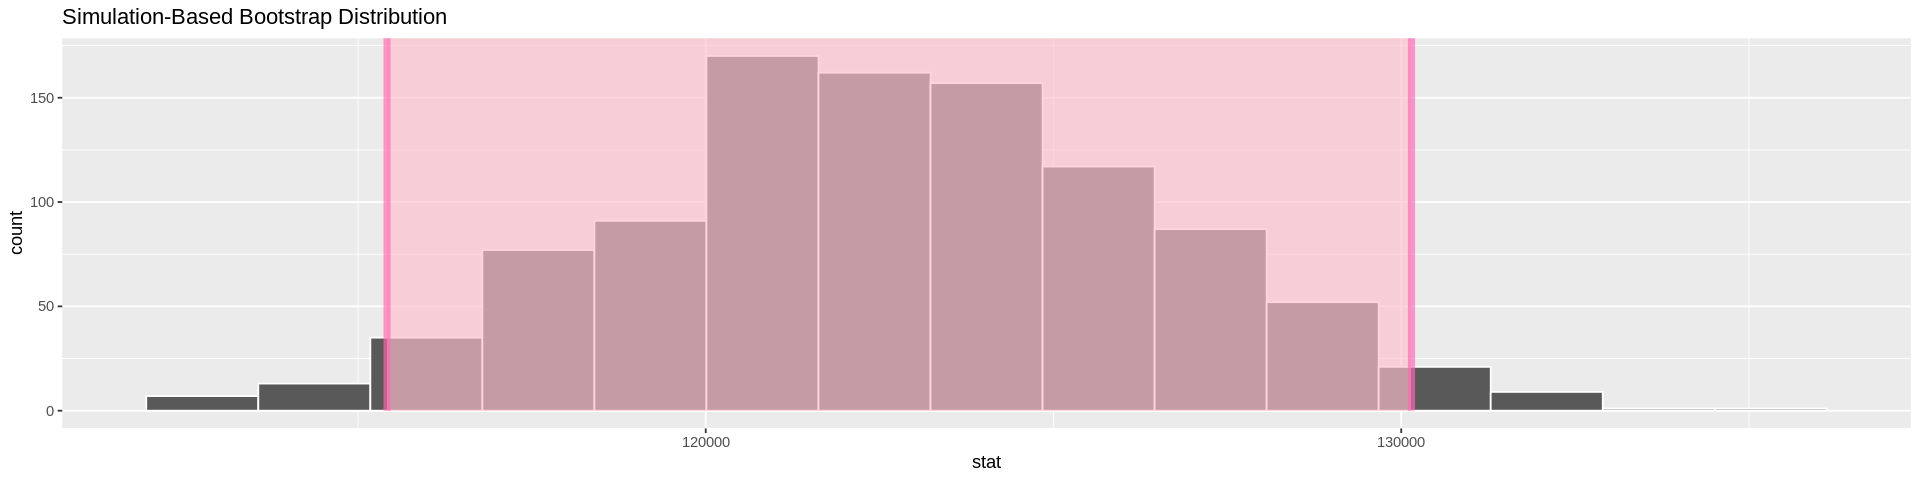

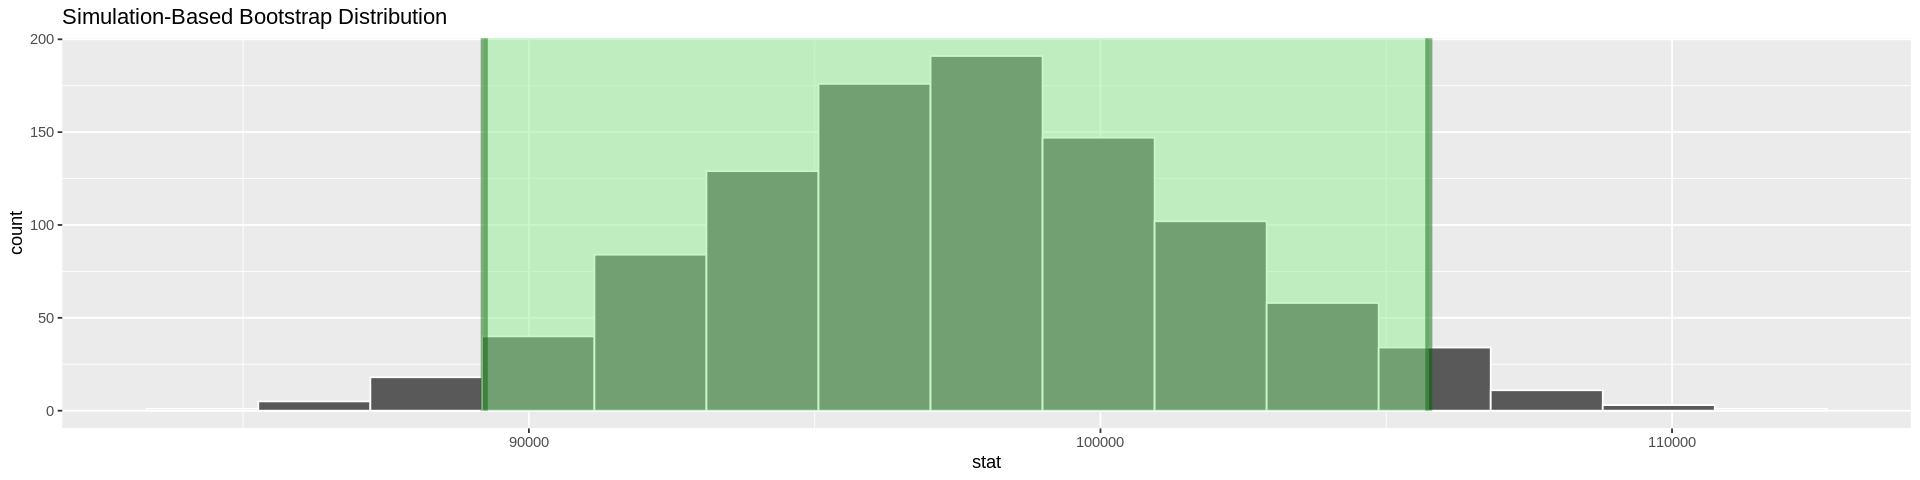

In [9]:
# Construct 95% confidence intervals using percentile method with bootstraping

# Fully-remote:

fully_remote_resample  <-  fully_remote %>%
    specify(response = salary_in_usd) %>%
    generate(reps = 1000, type = "bootstrap") %>%                        
    calculate(stat = "mean") 
# head(fully_remote_resample)

fully_remote_percentile_ci <- fully_remote_resample %>% 
  get_confidence_interval(level = 0.95, type = "percentile") 
fully_remote_percentile_ci

fully_remote_ci_plot <- 
    visualize(fully_remote_resample) + 
    shade_ci(endpoints = fully_remote_percentile_ci, color = "hotpink", fill = "pink", alpha = 0.66)
fully_remote_ci_plot


# Non-fully-remote:

non_fully_remote_resample  <- non_fully_remote %>%
    specify(response = salary_in_usd) %>%
    generate(reps = 1000, type = "bootstrap") %>%                        
    calculate(stat = "mean")    
# head(non_fully_remote_resample)

non_fully_remote_percentile_ci <- non_fully_remote_resample %>% 
  get_confidence_interval(level = 0.95, type = "percentile") 
non_fully_remote_percentile_ci

non_fully_remote_ci_plot <- 
    visualize(non_fully_remote_resample) + 
    shade_ci(endpoints = non_fully_remote_percentile_ci, color = "dark green", fill = "light green", alpha = 0.48)
non_fully_remote_ci_plot

To improve:
- covert to same scale with infer package
- title and labels with infer package



To write: 
- 95% confident that ...
- However, "Limitations of Confidence Interval:" see notes.

## Hypothesis Testing

### Boxplots

In [10]:
head(remote_binary)

salary_in_usd,company_location,company_size,experience_level,fully_remote
<dbl>,<chr>,<chr>,<chr>,<lgl>
79833,DE,L,MI,FALSE
260000,JP,S,SE,FALSE
109024,GB,M,SE,FALSE
20000,HN,S,MI,FALSE
150000,US,L,SE,FALSE
72000,US,L,EN,TRUE


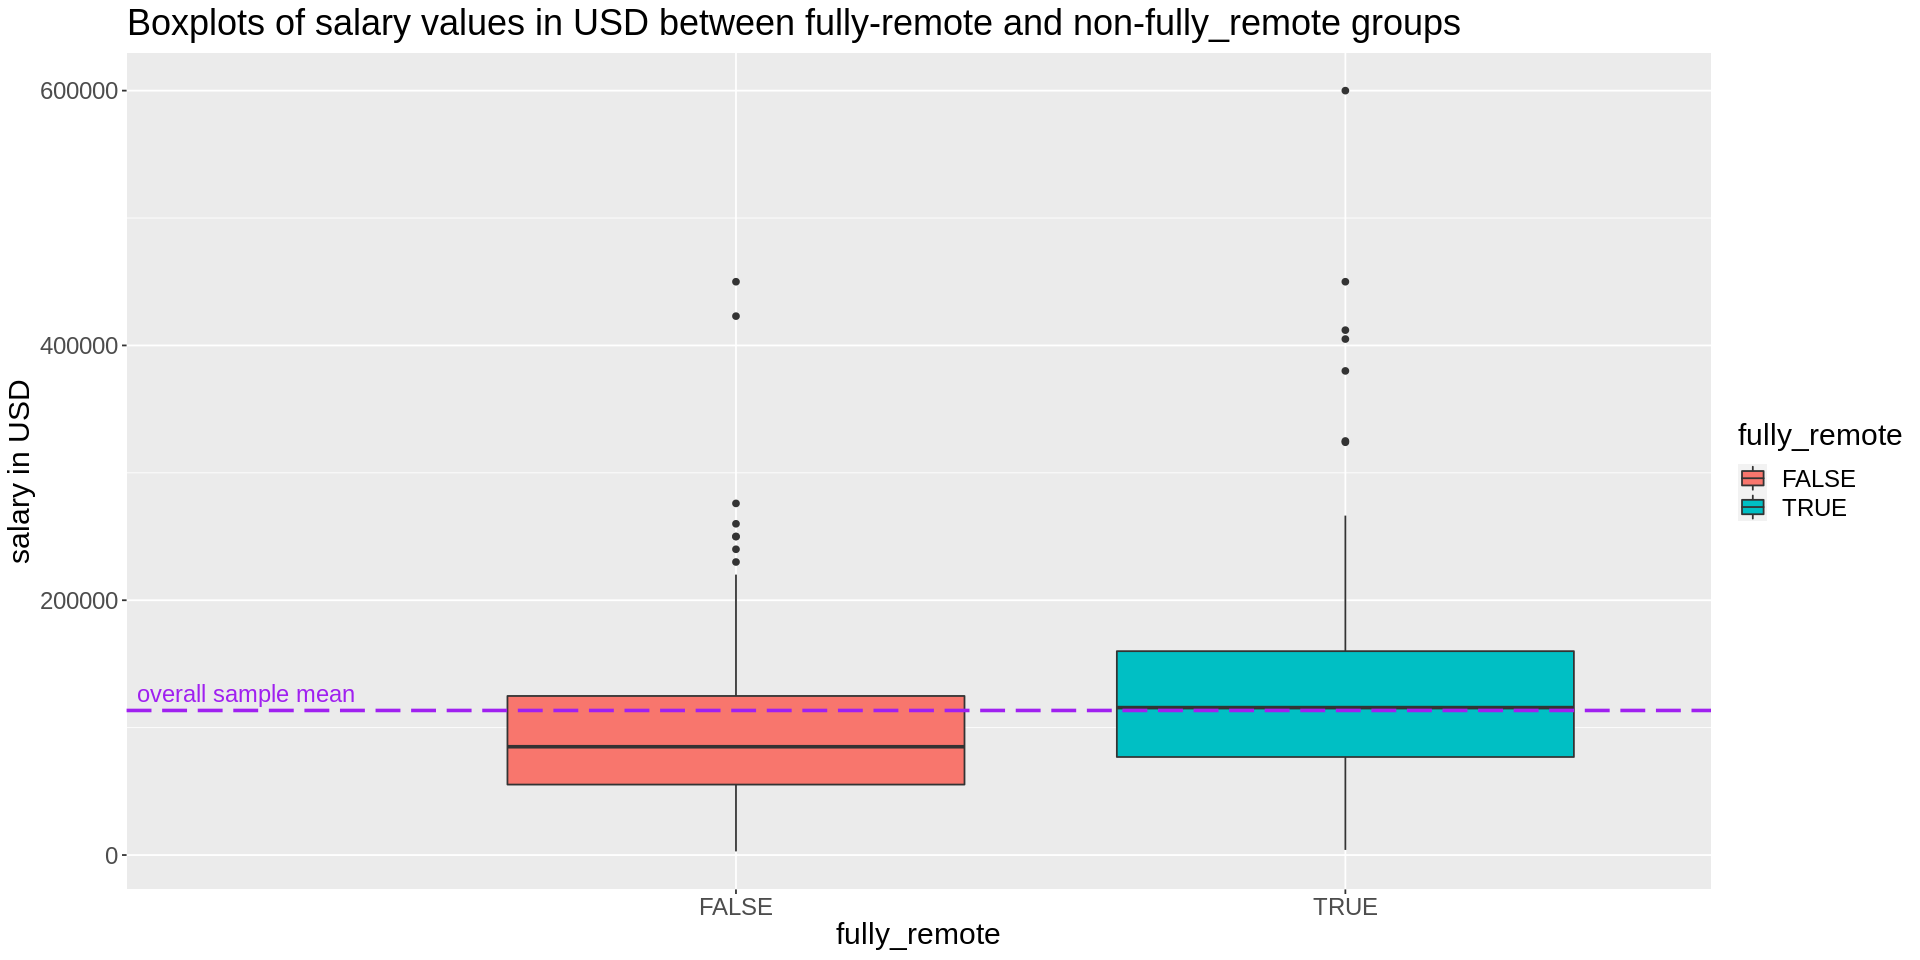

In [77]:
options(repr.plot.width = 16, repr.plot.height = 8)
options("scipen"=10, "digits"=4)

boxplots_all <- remote_binary %>%  
    ggplot(aes(x = fully_remote, y = salary_in_usd, fill = fully_remote)) + 
    geom_boxplot() + 
    ylab("salary in USD") +
    ggtitle("Boxplots of salary values in USD between fully-remote and non-fully_remote groups") +
    theme(text = element_text(size=18)) +
    # geom_hline(yintercept = median_overall, color="red", size = 1, linetype = "longdash") 
    geom_hline(yintercept = mean_overall, color="purple", size = 1, linetype = "longdash") +
        annotate("text", x = 0, y = mean_overall,label = "overall sample mean", color = "purple", size=5, hjust = -0.05, vjust = -0.5)

boxplots_all

- notice a big outlier?
    - may affect results?
- executive position are not representative of population, would therefore remove?

In [12]:
## Yvonne's Orignal 

# hypothesis test (two group)
# make the remote_ratio column two categories, so that it is easier to work with
# remote_binary <- df %>% 
#     mutate(full_remote = (remote_ratio == 100)) %>% 
#     select(-remote_ratio)
# head(remote_binary)

#calculate observed test statistic 
obs_diff_in_means <- 
    remote_binary %>% 
    specify(formula = salary_in_usd ~ fully_remote) %>%
    calculate(stat = "diff in means", order = c("TRUE", "FALSE"))
obs_diff_in_means

# build the null distribution
null_dist <-remote_binary  %>%
    specify(formula = salary_in_usd ~ fully_remote) %>% 
    hypothesize(null = "independence") %>% 
    generate(reps = 10000, type = "permute") %>% 
    calculate(stat="diff in means", order = c("TRUE", "FALSE"))
head(null_dist)

# # visualization 
# options(repr.plot.width = 16, repr.plot.height = 6)
# options("scipen"=10, "digits"=4)

# diff_in_medians_plot <-
#     visualize(null_dist, bins = 10) + 
#     shade_p_value(obs_stat = obs_diff_in_means, direction = "right") +
#     xlab("Difference in mean") +
#     theme(text = element_text(size = 20))
# diff_in_medians_plot

# get p value
p_value <- null_dist %>% 
    get_p_value(obs_stat = obs_diff_in_means, direction = "right")
p_value


stat
<dbl>
25373


replicate,stat
<int>,<dbl>
1,-337.3
2,-9106.8
3,3029.6
4,7976.4
5,-9972.4
6,-7135.0


Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


In [13]:
# # # take out outlier?

# remote_binary_outlier_remove <- remote_binary %>%
#     filter(salary_in_usd <= 300000)
#     # filter(salary_in_usd <= 150000)
#     # filter(experience_level == "EN")
#     # filter(experience_level == "EX")
#     # filter(experience_level == "MI")
#     # filter(experience_level == "SE")

# #calculate observed test statistic 
# obs_diff_in_means_outlier_remove <- remote_binary_outlier_remove %>% 
#     specify(formula = salary_in_usd ~ fully_remote) %>%
#     calculate(stat = "diff in means", order = c("TRUE", "FALSE"))
# obs_diff_in_means_outlier_remove

# # build the null distribution
# null_dist_outlier_remove <- remote_binary_outlier_remove %>%
#     specify(formula = salary_in_usd ~ fully_remote) %>% 
#     hypothesize(null = "independence") %>% 
#     generate(reps = 10000, type = "permute") %>% 
#     calculate(stat = "diff in means", order = c("TRUE", "FALSE"))
# head(null_dist_outlier_remove)

# # # visualization 
# # options(repr.plot.width = 16, repr.plot.height = 6)
# # options("scipen"=10, "digits"=4)

# # diff_in_medians_plot <-
# #     visualize(null_dist, bins = 10) + 
# #     shade_p_value(obs_stat = obs_diff_in_means, direction = "right") +
# #     xlab("Difference in mean") +
# #     theme(text = element_text(size = 20))
# # diff_in_medians_plot

# # get p value
# p_value_outlier_remove <- null_dist_outlier_remove %>% 
#     get_p_value(obs_stat = obs_diff_in_means_outlier_remove, direction = "right")
# p_value_outlier_remove


In [46]:
## boxplot just for exprience level

# options(repr.plot.width = 16, repr.plot.height = 6)
# options("scipen"=10, "digits"=4)

# boxplots_exp_fully_remote <- fully_remote %>%  
#     ggplot(aes(x = experience_level, y = salary_in_usd, fill = experience_level)) + 
#     geom_boxplot() + 
#     ylab("salary in USD") +
#     ggtitle("Boxplots of salary values in USD for FULLY-REMOTE among different experience level") +
#     theme(text = element_text(size=18)) +
#     # geom_hline(yintercept = median_overall, color="red", size = 1, linetype = "longdash") 
#     geom_hline(yintercept = mean_overall, color="red", size = 1, linetype = "longdash") 
# boxplots_exp_fully_remote


# boxplots_exp_non_fully_remote <- non_fully_remote %>%  
#     ggplot(aes(x = experience_level, y = salary_in_usd, fill = experience_level)) + 
#     geom_boxplot() + 
#     ylab("salary in USD") +
#     ggtitle("Boxplots of salary values in USD for NON-FULLY-REMOTE among different experience level") +
#     theme(text = element_text(size=18)) +
#     # geom_hline(yintercept = median_overall, color="red", size = 1, linetype = "longdash") 
#     geom_hline(yintercept = mean_overall, color="red", size = 1, linetype = "longdash") 

# boxplots_exp_non_fully_remote


In [42]:
# US_remote_binary <- remote_binary %>% 
#     filter(company_location == "US")
# head(US_remote_binary)

# CA_remote_binary <- remote_binary %>% 
#     filter(company_location == "CA")
# head(CA_remote_binary)

# Others_remote_binary <-
#     remote_binary %>% 
#     filter(company_location != "CA", 
#            company_location !="US")
# head(Others_remote_binary)

In [44]:
## boxplot for divided dataframes - replaced

# options(repr.plot.width = 16, repr.plot.height = 6)
# options("scipen"=10, "digits"=4)

# # With exprience levels:

# # # Within US between remote groups among 4 exprience levels:
# # boxplots_US <- US_remote_binary %>%  
# #     ggplot(aes(x = fully_remote, y = salary_in_usd, fill = experience_level)) + 
# #     geom_boxplot() + 
# #     ylab("salary in USD") +
# #     ggtitle("Boxplots of salary values in USD for US between remote groups") +
# #     theme(text = element_text(size=18)) +
# #     # geom_hline(yintercept = median_overall, color="red", size = 1, linetype = "longdash") 
# #     geom_hline(yintercept = mean_overall, color="red", size = 1, linetype = "longdash") 
# # boxplots_US

# # # Within Canada between remote groups among 4 exprience levels:
# # boxplots_CA <- CA_remote_binary %>%  
# #     ggplot(aes(x = fully_remote, y = salary_in_usd, fill = experience_level)) + 
# #     geom_boxplot() + 
# #     ylab("salary in USD") +
# #     ggtitle("Boxplots of salary values in USD for CANADA between remote groups") +
# #     theme(text = element_text(size=18)) +
# #     # geom_hline(yintercept = median_overall, color="red", size = 1, linetype = "longdash") 
# #     geom_hline(yintercept = mean_overall, color="red", size = 1, linetype = "longdash") 
# # boxplots_CA

# # # Within other countries between remote groups among 4 exprience levels:
# # boxplots_Others <- Others_remote_binary %>%  
# #     ggplot(aes(x = fully_remote, y = salary_in_usd, fill = experience_level)) + 
# #     geom_boxplot() + 
# #     ylab("salary in USD") +
# #     ggtitle("Boxplots of salary values in USD for Other countries between remote groups") +
# #     theme(text = element_text(size=18)) +
# #     # geom_hline(yintercept = median_overall, color="red", size = 1, linetype = "longdash") 
# #     geom_hline(yintercept = mean_overall, color="red", size = 1, linetype = "longdash") 
# # boxplots_Others


# # Without experience levels:

# # Within US between remote groups:
# boxplots_US <- US_remote_binary %>%  
#     ggplot(aes(x = fully_remote, y = salary_in_usd)) + 
#     geom_boxplot() + 
#     ylab("salary in USD") +
#     ggtitle("Boxplots of salary values in USD for US between remote groups") +
#     theme(text = element_text(size=18)) +
#     # geom_hline(yintercept = median_overall, color="red", size = 1, linetype = "longdash") 
#     geom_hline(yintercept = mean_overall, color="red", size = 1, linetype = "longdash") 
# boxplots_US

# # Within Canada between remote groups:
# boxplots_CA <- CA_remote_binary %>%  
#     ggplot(aes(x = fully_remote, y = salary_in_usd)) + 
#     geom_boxplot() + 
#     ylab("salary in USD") +
#     ggtitle("Boxplots of salary values in USD for CANADA between remote groups") +
#     theme(text = element_text(size=18)) +
#     # geom_hline(yintercept = median_overall, color="red", size = 1, linetype = "longdash") 
#     geom_hline(yintercept = mean_overall, color="red", size = 1, linetype = "longdash") 
# boxplots_CA

# # Within other countries between remote groups:
# boxplots_Others <- Others_remote_binary %>%  
#     ggplot(aes(x = fully_remote, y = salary_in_usd)) + 
#     geom_boxplot() + 
#     ylab("salary in USD") +
#     ggtitle("Boxplots of salary values in USD for Other countries between remote groups") +
#     theme(text = element_text(size=18)) +
#     # geom_hline(yintercept = median_overall, color="red", size = 1, linetype = "longdash") 
#     geom_hline(yintercept = mean_overall, color="red", size = 1, linetype = "longdash") 
# boxplots_Others

In [29]:
# remote_binary_region_groups <- remote_binary["company_location"][remote_binary[] != ...] %>%
#     mutate(region = )
 
# remote_binary_region_groups <- remote_binary["company_location"][remote_binary["company_location"] != c("US","CA") ] <- "Others"
# head(remote_binary_region_groups)

tally_remote_binary <- remote_binary %>%
    group_by(company_location) %>%
    summarise(total = length(company_location))
tally_remote_binary
    

# Duplicate original cleaned dataframe to re-assigned region groups
remote_binary_region_groups <- remote_binary

# Re-categorize countries into US, Canada, and Others
# remote_binary_region_groups["company_location"][remote_binary["company_location"] != c("US", "CA") ] <- "Others"
remote_binary_region_groups["company_location"][remote_binary_region_groups["company_location"] != "US" & remote_binary_region_groups["company_location"] != "CA"] <- "Others"
# glimpse(remote_binary_region_groups)
# head(remote_binary_region_groups)
# remote_binary_region_groups

tally_remote_binary_region_groups <- remote_binary_region_groups %>%
    group_by(company_location) %>%
    summarise(total = length(company_location))
tally_remote_binary_region_groups

# remote_binary_region_groups %>%
#     filter(company_location != "US") %>%
#     filter(company_location != "Others") 
# remote_binary_region_groups


# df["group_b"][df["group_b"] == 11] <- 77

company_location,total
<chr>,<int>
AE,3
AS,1
AT,4
AU,3
BE,2
BR,3
CA,30
CH,2
CL,1


company_location,total
<chr>,<int>
CA,30
Others,212
US,346


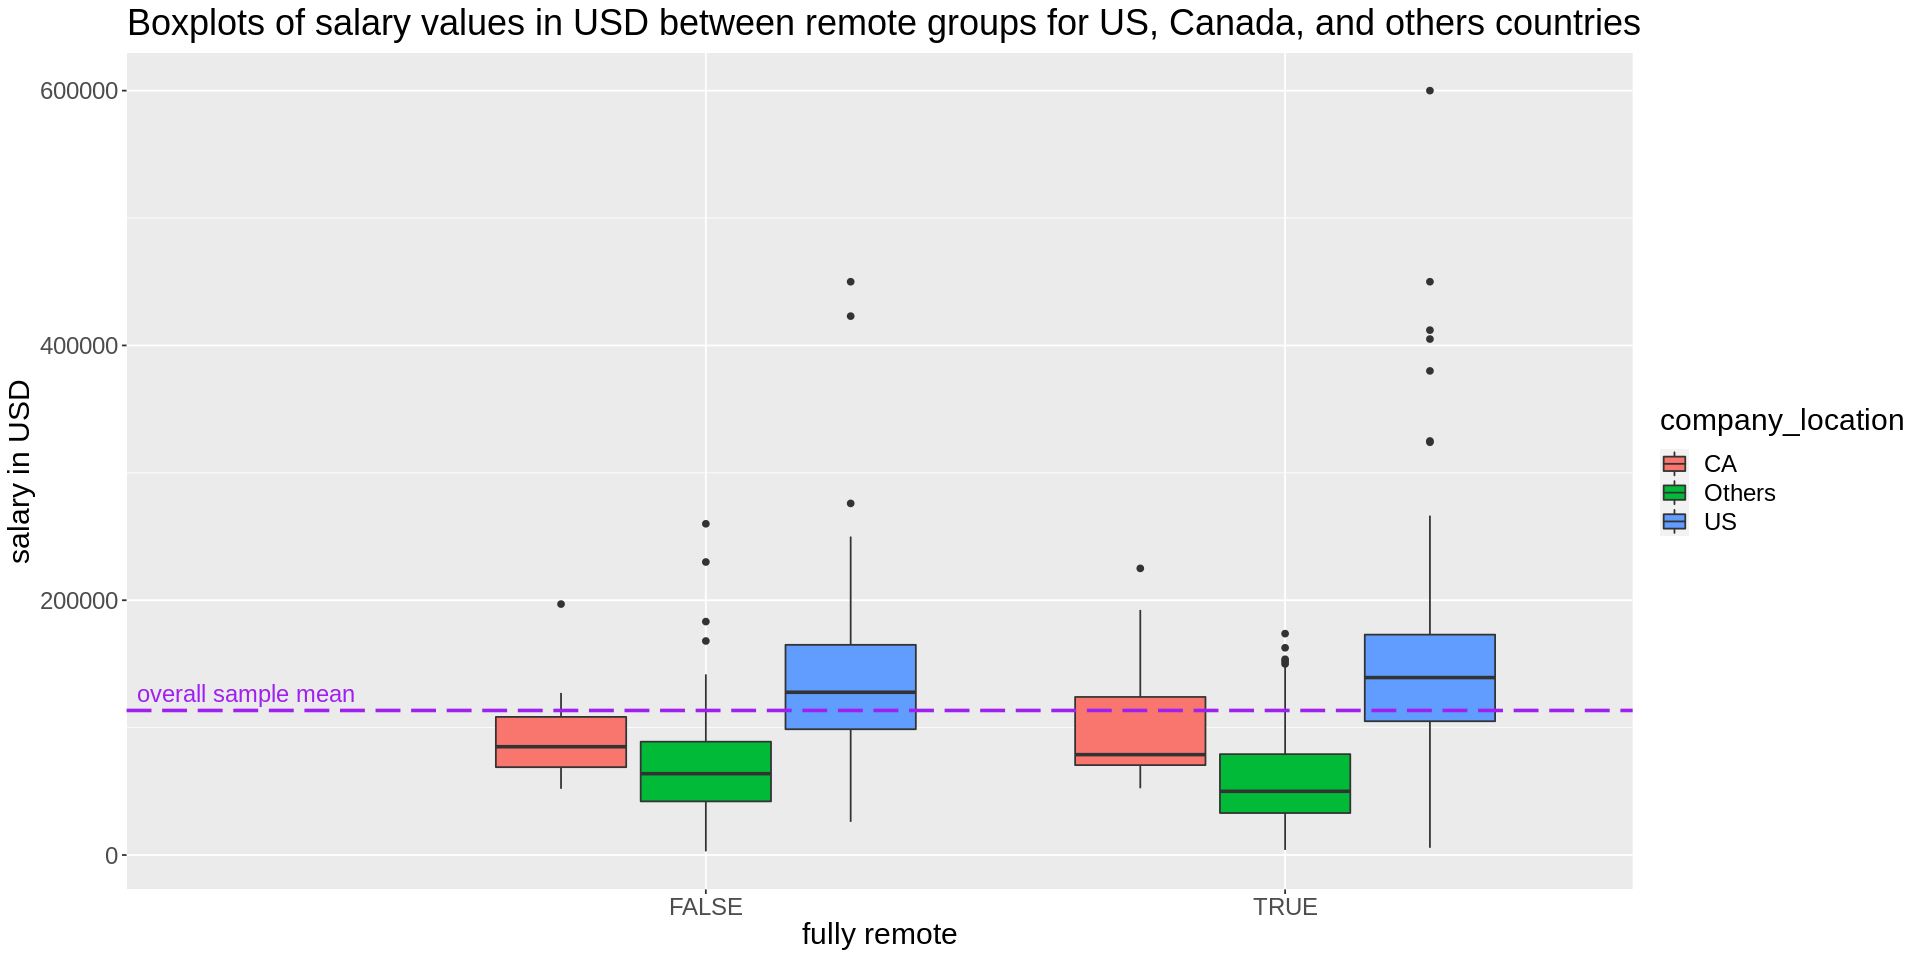

In [80]:
boxplots_remote_regions <- remote_binary_region_groups %>%  
    ggplot(aes(x = fully_remote, y = salary_in_usd, fill = company_location)) + 
    geom_boxplot() + 
    xlab("fully remote") +
    ylab("salary in USD") +
    ggtitle("Boxplots of salary values in USD between remote groups for US, Canada, and others countries") +
    theme(text = element_text(size=18)) +
    # geom_hline(yintercept = median_overall, color="red", size = 1, linetype = "longdash") 
    geom_hline(yintercept = mean_overall, color="purple", size = 1, linetype = "longdash") +
        annotate("text", x = 0, y = mean_overall,label = "overall sample mean", color = "purple", size = 5, hjust = -0.05, vjust = -0.5)
boxplots_remote_regions

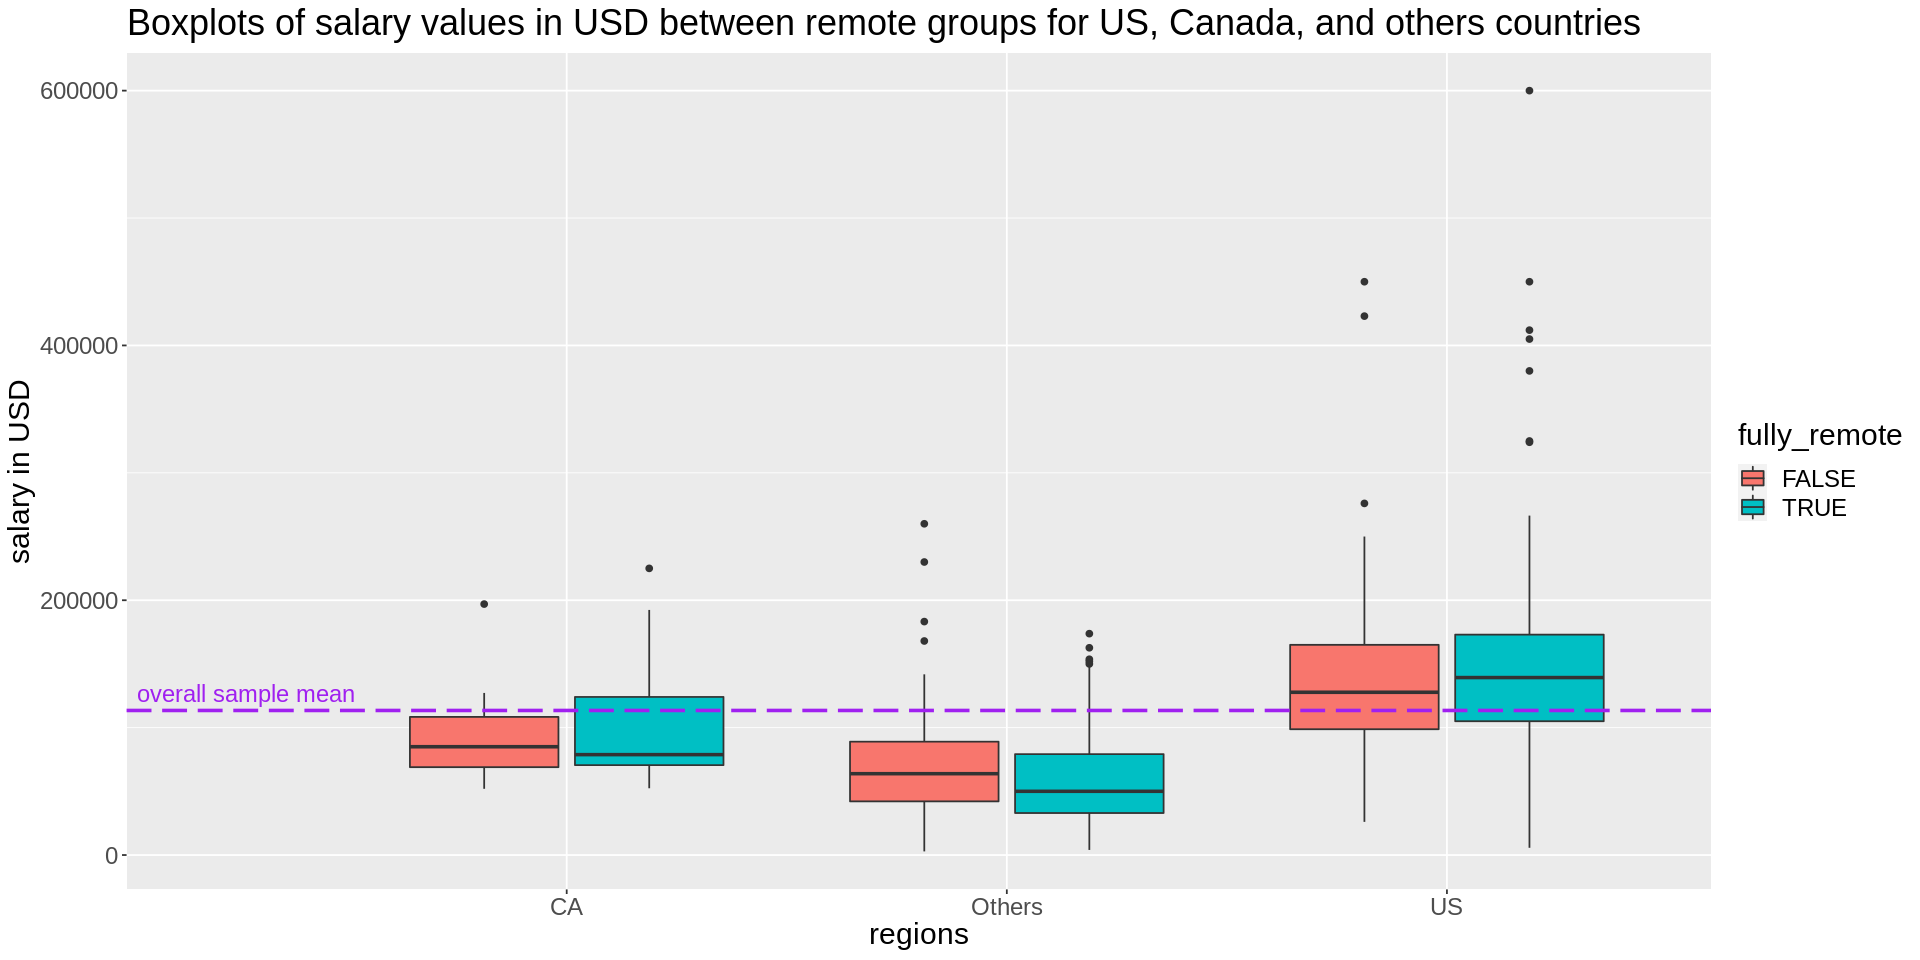

In [81]:
boxplots_regions_remote <- remote_binary_region_groups %>%  
    ggplot(aes(x = company_location, y = salary_in_usd, fill = fully_remote)) + 
    geom_boxplot() + 
    xlab("regions") +
    ylab("salary in USD") +
    ggtitle("Boxplots of salary values in USD between remote groups for US, Canada, and others countries") +
    theme(text = element_text(size=18)) +
    # geom_hline(yintercept = median_overall, color="red", size = 1, linetype = "longdash") 
    geom_hline(yintercept = mean_overall, color="purple", size = 1, linetype = "longdash") +
        annotate("text", x = 0, y = mean_overall,label = "overall sample mean", color = "purple", size = 5, hjust = -0.05, vjust = -0.5)
boxplots_regions_remote

given obvious differences among different regions and clear outliers in each group, choose to use IQR instead of repeated hypothesis testing to conduct more in-depth investigations about how salaries differ between fully-remote and conventional groups among different regions? 

In [146]:
## Inter-quartile range:

# non fully remote group:
lower_quantile_non_fully_remote <- 
    non_fully_remote %>% 
    pull(salary_in_usd) %>% 
    quantile(0.25)
lower_quantile_non_fully_remote

upper_quantile_non_fully_remote <- 
    non_fully_remote %>% 
    pull(salary_in_usd) %>% 
    quantile(0.75)
upper_quantile_non_fully_remote

median_non_fully_remote <- non_fully_remote %>% 
    summarise(median = median(salary_in_usd)) %>% 
    pull()
median_non_fully_remote



# fully remote group:
lower_quantile_fully_remote <- 
    fully_remote %>% 
    pull(salary_in_usd) %>% 
    quantile(0.25)
lower_quantile_fully_remote

upper_quantile_fully_remote <- 
    fully_remote %>% 
    pull(salary_in_usd) %>% 
    quantile(0.75)
upper_quantile_fully_remote

median_fully_remote <- fully_remote %>% 
    summarise(median = median(salary_in_usd)) %>% 
    pull()
median_fully_remote

25% 
55314

75% 
124833

[1] 85000

25% 
76944

75% 
160000

[1] 115717

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


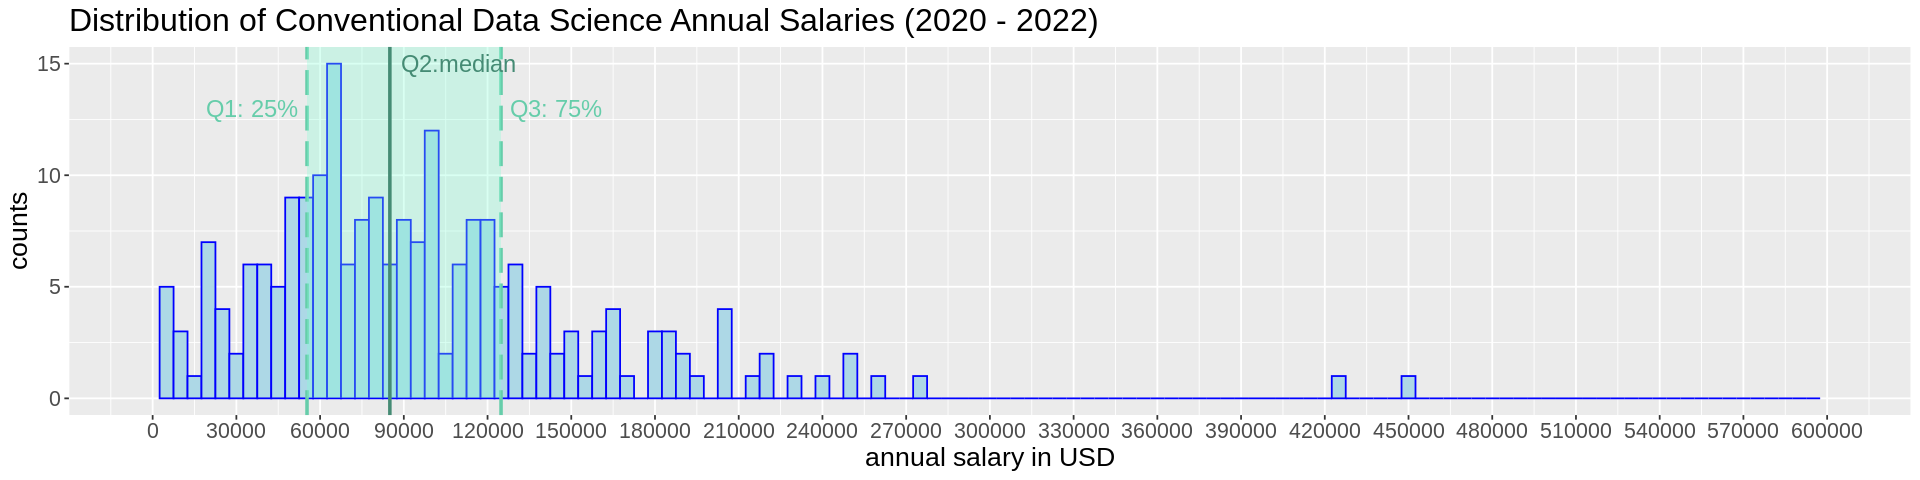

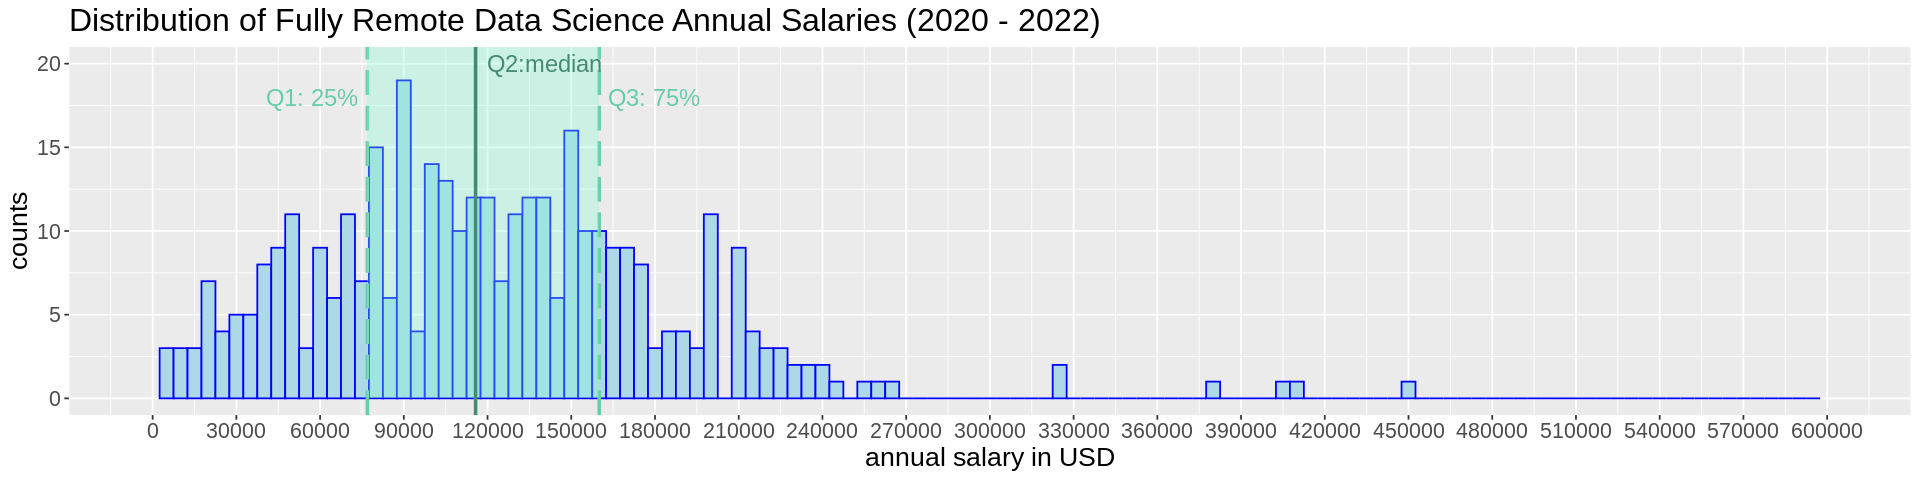

In [159]:
options(repr.plot.width = 16, repr.plot.height = 4)
options("scipen"=10, "digits"=4)

# non fully remote group:
plot_IQR_non_fully_remote <- non_fully_remote %>%
    ggplot(aes(x = salary_in_usd)) +
    geom_histogram(binwidth = 5000, color = 'blue', fill = 'light blue') +
    labs(title = "Distribution of Conventional Data Science Annual Salaries (2020 - 2022)",
         x = 'annual salary in USD',
         y = 'counts') + 
        theme(text = element_text(size = 16)) +

    # add in coloured vertical lines with labels for group mean and group meadian as reference:
    geom_vline(xintercept = lower_quantile_non_fully_remote, colour = 'aquamarine3', size = 1, linetype = "longdash") +
        annotate("text", x = lower_quantile_non_fully_remote, y = 13, label = "Q1: 25%", color = 'aquamarine3', size = 5, hjust = 1.1) +
    geom_vline(xintercept = upper_quantile_non_fully_remote, colour = 'aquamarine3', size = 1, linetype = "longdash") +
        annotate("text", x = upper_quantile_non_fully_remote, y = 13, label = "Q3: 75%", color = 'aquamarine3', size = 5, hjust = -0.1) +
    annotate("rect", xmin = lower_quantile_non_fully_remote, xmax = upper_quantile_non_fully_remote, ymin = 0, ymax = Inf,
             fill = "aquamarine",
             alpha = 0.3) +
    geom_vline(xintercept = median_non_fully_remote, colour = 'aquamarine4', size = 1, linetype = "solid") +
        annotate("text", x = median_non_fully_remote, y = 15, label = "Q2:median", color = 'aquamarine4', size=5, hjust = -0.1) +
    
    # # add grey vertical lines for sample mean and sample meadian from sections above:
    # geom_vline(xintercept = 113468, colour = 'grey', size = 1, linetype = "solid") +
    # geom_vline(xintercept = 104196, colour = 'grey', size = 1, linetype = "longdash") +

   # refine the limits and breaks of the x and y scales:
    scale_y_continuous(limits = c(0, 15), breaks = seq(0, 15, 5)) +
    scale_x_continuous(limits = c(0, 600001), breaks = seq(0, 600001, 30000)) 

plot_IQR_non_fully_remote


# fully remote group:
remote_plot <- fully_remote %>%
    ggplot(aes(x = salary_in_usd)) +
    geom_histogram(binwidth = 5000, color = 'blue', fill = 'light blue') +
    labs(title = "Distribution of Fully Remote Data Science Annual Salaries (2020 - 2022)",
         x = 'annual salary in USD',
         y = 'counts') + 
        theme(text = element_text(size = 16)) +


    geom_vline(xintercept = lower_quantile_fully_remote, colour = 'aquamarine3', size = 1, linetype = "longdash") +
        annotate("text", x = lower_quantile_fully_remote, y = 18, label = "Q1: 25%", color = 'aquamarine3', size = 5, hjust = 1.1) +
    geom_vline(xintercept = upper_quantile_fully_remote, colour = 'aquamarine3', size = 1, linetype = "longdash") +
        annotate("text", x = upper_quantile_fully_remote, y = 18, label = "Q3: 75%", color = 'aquamarine3', size = 5, hjust = -0.1) +
    annotate("rect", xmin = lower_quantile_fully_remote, xmax = upper_quantile_fully_remote, ymin = 0, ymax = Inf,
             fill = "aquamarine",
             alpha = 0.3) +
    geom_vline(xintercept = median_fully_remote, colour = 'aquamarine4', size = 1, linetype = "solid") +
        annotate("text", x = median_fully_remote, y = 20, label = "Q2:median", color = 'aquamarine4', size=5, hjust = -0.1) +
    


    # # add in coloured vertical lines with labels for group mean and group meadian as reference:
    # geom_vline(xintercept = 122874.89, colour = 'hot pink', size = 1, linetype = "solid") +
    #     annotate("text", x = 122874.89, y = 20, label = "mean = 122874.89", color = "hot pink", size = 5, hjust = 2.5) +
    # geom_vline(xintercept = 115717, colour = '#00827f', alpha = 0.36, size = 1, linetype = "longdash") +
    #     annotate("text", x = 115717, y = 20, label = "median = 115717", color = '#00827f', alpha = 0.36, size=5, hjust = 3) +

    # # add grey vertical lines for sample mean and sample meadian from sections above:
    # geom_vline(xintercept = 113468, colour = 'grey', size = 1, linetype = "solid") +
    # geom_vline(xintercept = 104196, colour = 'grey', size = 1, linetype = "longdash") +

   # refine the limits and breaks of the x and y scales:
    scale_y_continuous(limits = c(0, 20), breaks = seq(0, 20, 5)) +
    scale_x_continuous(limits = c(0, 600001), breaks = seq(0, 600001, 30000)) 

remote_plot


# The warning message is only caused by adjusting the y-axis breaks and limits, which does not affect calculation for analysis.
# We double-checked the raw data, and there is no "missing values" for the two removed rows in the dataset itself.
# This specific data visualization warning message will be dealt with within the report.


In [97]:
# # within country cross remote

# us_remote_binary <- remote_binary %>% 
#     filter(company_location == "US")
# head(us_remote_binary)


# ca_remote_binary <- remote_binary %>% 
#     filter(company_location == "CA")
# head(ca_remote_binary)


# others_remote_binary <- remote_binary %>% 
#     filter(company_location != "CA", 
#            company_location !="US")
# head(others_remote_binary)


In [98]:
## original country means across population

#calculate observed test statistic 
us_obs_diff_in_means <- 
    us_remote_binary %>% 
    specify(formula = salary_in_usd ~ fully_remote) %>%
    calculate(stat = "diff in means", order = c("TRUE", "FALSE"))
# us_obs_diff_in_means

# build the null distribution
us_null_dist <- us_remote_binary %>%
    specify(formula = salary_in_usd ~ fully_remote) %>% 
    hypothesize(null = "independence") %>% 
    generate(reps = 10000, type = "permute") %>% 
    calculate(stat="diff in means", order = c("TRUE", "FALSE"))
# head(us_null_dist)

# # visualization 
# diff_in_medians_plot <-
#     visualize(null_dist, bins = 10) + 
#     shade_p_value(obs_stat = obs_diff_in_means, direction = "right") +
#     xlab("Difference in mean") +
#     theme(text = element_text(size = 20))
# diff_in_medians_plot

# get p value
us_p_value <- us_null_dist %>% 
    get_p_value(obs_stat = us_obs_diff_in_means, direction = "right") %>%
    pull()
# us_p_value


#calculate observed test statistic 
ca_obs_diff_in_means <- 
    ca_remote_binary %>% 
    specify(formula = salary_in_usd ~ fully_remote) %>%
    calculate(stat = "diff in means", order = c("TRUE", "FALSE"))
# ca_obs_diff_in_means

# build the null distribution
ca_null_dist <- ca_remote_binary %>%
    specify(formula = salary_in_usd ~ fully_remote) %>% 
    hypothesize(null = "independence") %>% 
    generate(reps = 10000, type = "permute") %>% 
    calculate(stat="diff in means", order = c("TRUE", "FALSE"))
# head(ca_null_dist)

# # visualization 
# diff_in_medians_plot <-
#     visualize(null_dist, bins = 10) + 
#     shade_p_value(obs_stat = obs_diff_in_means, direction = "right") +
#     xlab("Difference in mean") +
#     theme(text = element_text(size = 20))
# diff_in_medians_plot

# get p value
ca_p_value <- ca_null_dist %>% 
    get_p_value(obs_stat = ca_obs_diff_in_means, direction = "right") %>%
    pull()
# ca_p_value


#calculate observed test statistic 
others_obs_diff_in_means <- 
    others_remote_binary %>% 
    specify(formula = salary_in_usd ~ fully_remote) %>%
    calculate(stat = "diff in means", order = c("TRUE", "FALSE"))
# obs_diff_in_means

# build the null distribution
others_null_dist <- others_remote_binary %>%
    specify(formula = salary_in_usd ~ fully_remote) %>% 
    hypothesize(null = "independence") %>% 
    generate(reps = 10000, type = "permute") %>% 
    calculate(stat="diff in means", order = c("TRUE", "FALSE"))
# head(others_null_dist)

# # visualization 
# diff_in_medians_plot <-
#     visualize(null_dist, bins = 10) + 
#     shade_p_value(obs_stat = obs_diff_in_means, direction = "right") +
#     xlab("Difference in mean") +
#     theme(text = element_text(size = 20))
# diff_in_medians_plot

# get p value
others_p_value <- others_null_dist %>% 
    get_p_value(obs_stat = others_obs_diff_in_means, direction = "right") %>%
    pull()
# others_p_value


cat(" p-value for US region:", us_p_value, "\n", "p-value for Canada region:", ca_p_value, "\n", "p-value for other countires:", others_p_value)


 p-value for US region: 0.1281 
 p-value for Canada region: 0.3434 
 p-value for other countires: 0.9257

In [ ]:
# ## change mean to median 

# # hypothesis test (two group)
# # make the remote_ratio column two categories, so that it is easier to work with
# # remote_binary <- df %>% 
# #     mutate(full_remote = (remote_ratio == 100)) %>% 
# #     select(-remote_ratio)
# # head(remote_binary)

# #calculate observed test statistic 
# obs_diff_in_meds <- remote_binary %>% 
#     specify(formula = salary_in_usd ~ fully_remote) %>%
#     calculate(stat = "diff in medians", order = c("TRUE", "FALSE"))
# obs_diff_in_meds

# # build the null distribution
# null_dist_meds <- remote_binary  %>%
#     specify(formula = salary_in_usd ~ fully_remote) %>% 
#     hypothesize(null = "independence") %>% 
#     generate(reps = 10000, type = "permute") %>% 
#     calculate(stat = "diff in medians", order = c("TRUE", "FALSE"))
# head(null_dist_meds)

# # # visualization 
# # diff_in_medians_plot <-
# #     visualize(null_dist, bins = 10) + 
# #     shade_p_value(obs_stat = obs_diff_in_means, direction = "right") +
# #     xlab("Difference in mean") +
# #     theme(text = element_text(size = 20))
# # diff_in_medians_plot

# # get p value
# p_value_meds <- null_dist_meds %>% 
#     get_p_value(obs_stat = obs_diff_in_meds, direction = "right")
# p_value_meds


In [22]:
# ## change country mean to median

# #calculate observed test statistic 
# us_obs_diff_in_meds <- 
#     us_remote_binary %>% 
#     specify(formula = salary_in_usd ~ fully_remote) %>%
#     calculate(stat = "diff in medians", order = c("TRUE", "FALSE"))
# # us_obs_diff_in_meds

# # build the null distribution
# us_null_dist_meds <- us_remote_binary %>%
#     specify(formula = salary_in_usd ~ fully_remote) %>% 
#     hypothesize(null = "independence") %>% 
#     generate(reps = 10000, type = "permute") %>% 
#     calculate(stat="diff in medians", order = c("TRUE", "FALSE"))
# head(us_null_dist_meds)

# # # visualization 
# # diff_in_medians_plot <-
# #     visualize(null_dist, bins = 10) + 
# #     shade_p_value(obs_stat = obs_diff_in_means, direction = "right") +
# #     xlab("Difference in mean") +
# #     theme(text = element_text(size = 20))
# # diff_in_medians_plot

# # get p value
# us_p_value_meds <- us_null_dist_meds %>% 
#     get_p_value(obs_stat = us_obs_diff_in_meds, direction = "right")
# us_p_value_meds


# #calculate observed test statistic 
# ca_obs_diff_in_meds <- 
#     ca_remote_binary %>% 
#     specify(formula = salary_in_usd ~ fully_remote) %>%
#     calculate(stat = "diff in medians", order = c("TRUE", "FALSE"))
# # ca_obs_diff_in_meds

# # build the null distribution
# ca_null_dist_meds <- ca_remote_binary %>%
#     specify(formula = salary_in_usd ~ fully_remote) %>% 
#     hypothesize(null = "independence") %>% 
#     generate(reps = 10000, type = "permute") %>% 
#     calculate(stat="diff in medians", order = c("TRUE", "FALSE"))
# head(ca_null_dist_meds)

# # # visualization 
# # diff_in_medians_plot <-
# #     visualize(null_dist, bins = 10) + 
# #     shade_p_value(obs_stat = obs_diff_in_means, direction = "right") +
# #     xlab("Difference in mean") +
# #     theme(text = element_text(size = 20))
# # diff_in_medians_plot

# # get p value
# ca_p_value_meds <- ca_null_dist_meds %>% 
#     get_p_value(obs_stat = ca_obs_diff_in_meds, direction = "right")
# ca_p_value_meds

# #calculate observed test statistic 
# other_obs_diff_in_meds <- 
#     other_remote_binary %>% 
#     specify(formula = salary_in_usd ~ fully_remote) %>%
#     calculate(stat = "diff in medians", order = c("TRUE", "FALSE"))
# # other_obs_diff_in_meds

# # build the null distribution
# other_null_dist_meds <- other_remote_binary %>%
#     specify(formula = salary_in_usd ~ fully_remote) %>% 
#     hypothesize(null = "independence") %>% 
#     generate(reps = 10000, type = "permute") %>% 
#     calculate(stat = "diff in medians", order = c("TRUE", "FALSE"))
# head(other_null_dist_meds)

# # # visualization 
# # diff_in_medians_plot <-
# #     visualize(null_dist, bins = 10) + 
# #     shade_p_value(obs_stat = obs_diff_in_means, direction = "right") +
# #     xlab("Difference in mean") +
# #     theme(text = element_text(size = 20))
# # diff_in_medians_plot

# # get p value
# other_p_value_meds <- other_null_dist_meds %>% 
#     get_p_value(obs_stat = other_obs_diff_in_meds, direction = "right")
# other_p_value_meds

In [23]:
# # changing order 

# #calculate observed test statistic 
# us_obs_diff_in_means <- 
#     us_remote_binary %>% 
#     specify(formula = salary_in_usd ~ fully_remote) %>%
#     calculate(stat = "diff in means", order = c("FALSE", "TRUE"))
# # obs_diff_in_means

# # build the null distribution
# us_null_dist <- us_remote_binary %>%
#     specify(formula = salary_in_usd ~ fully_remote) %>% 
#     hypothesize(null = "independence") %>% 
#     generate(reps = 10000, type = "permute") %>% 
#     calculate(stat="diff in means", order = c("FALSE", "TRUE"))
# head(null_dist)

# # # visualization 
# # diff_in_medians_plot <-
# #     visualize(null_dist, bins = 10) + 
# #     shade_p_value(obs_stat = obs_diff_in_means, direction = "right") +
# #     xlab("Difference in mean") +
# #     theme(text = element_text(size = 20))
# # diff_in_medians_plot

# # get p value
# us_p_value <- us_null_dist %>% 
#     get_p_value(obs_stat = us_obs_diff_in_means, direction = "right")
# us_p_value


# #calculate observed test statistic 
# ca_obs_diff_in_means <- 
#     ca_remote_binary %>% 
#     specify(formula = salary_in_usd ~ fully_remote) %>%
#     calculate(stat = "diff in means", order = c("FALSE","TRUE"))
# # obs_diff_in_means

# # build the null distribution
# ca_null_dist <- ca_remote_binary %>%
#     specify(formula = salary_in_usd ~ fully_remote) %>% 
#     hypothesize(null = "independence") %>% 
#     generate(reps = 10000, type = "permute") %>% 
#     calculate(stat="diff in means", order = c("FALSE", "TRUE"))
# head(ca_null_dist)

# # # visualization 
# # diff_in_medians_plot <-
# #     visualize(null_dist, bins = 10) + 
# #     shade_p_value(obs_stat = obs_diff_in_means, direction = "right") +
# #     xlab("Difference in mean") +
# #     theme(text = element_text(size = 20))
# # diff_in_medians_plot

# # get p value
# ca_p_value <- ca_null_dist %>% 
#     get_p_value(obs_stat = ca_obs_diff_in_means, direction = "right")
# ca_p_value


# #calculate observed test statistic 
# other_obs_diff_in_means <- 
#     other_remote_binary %>% 
#     specify(formula = salary_in_usd ~ fully_remote) %>%
#     calculate(stat = "diff in means", order = c("FALSE", "TRUE"))
# # obs_diff_in_means

# # build the null distribution
# other_null_dist <- other_remote_binary %>%
#     specify(formula = salary_in_usd ~ fully_remote) %>% 
#     hypothesize(null = "independence") %>% 
#     generate(reps = 10000, type = "permute") %>% 
#     calculate(stat="diff in means", order = c("FALSE", "TRUE"))
# head(other_null_dist)

# # # visualization 
# # diff_in_medians_plot <-
# #     visualize(null_dist, bins = 10) + 
# #     shade_p_value(obs_stat = obs_diff_in_means, direction = "right") +
# #     xlab("Difference in mean") +
# #     theme(text = element_text(size = 20))
# # diff_in_medians_plot

# # get p value
# other_p_value <- other_null_dist %>% 
#     get_p_value(obs_stat = other_obs_diff_in_means, direction = "right")
# other_p_value

### 2.3 Visualizations

- Hi Ziya :)

*Make sure to **interpret the results you obtain**. It’s not enough to just state what a 90% confidence interval is, for example.*

*Ensure your tables and/or figures are labeled with a figure/table number.
**Do you think one of bootstrapping or asymptotics is more appropriate than the other? Why or why not?** Explain why you think both methods gave you similar/different results, and whether you think one is more trustworthy than the other.*

### 2.4 Results and interpretations

- Z & Y

# 3. Discussion
*In this section, you’ll **interpret the results** you obtained in the previous section*
***with respect to the main question/goal of your project.***
- *Summarize what you found, and the implications/impact of your findings.*
- *If relevant, discuss whether your results were what you expected to find.*
- *Discuss future questions/research this study could lead to.*

### 3.1 Findings and implications

### 3.2 Expectations 

### 3.3 Future questions and research

# 4. References
*The same instructions for your proposal also applies here. You only need to **make changes if necessary (e.g., if feedback indicates so).***

“Ai-Jobs.net Salaries.” Salaries.ai, https://salaries.ai-jobs.net/. 

Bhatia, Ruchi. “Data Science Job Salaries.” Kaggle, 15 June 2022, https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries. 

Brynjolfsson, Erik, et al. “Covid-19 and Remote Work: An Early Look at US Data.” 2020, https://doi.org/10.3386/w27344.

Galanti, Teresa et al. “Work From Home During the COVID-19 Outbreak: The Impact on Employees' Remote Work Productivity, Engagement, and Stress.” Journal of occupational and environmental medicine vol. 63,7 (2021): e426-e432. doi:10.1097/JOM.0000000000002236